In [16]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, Aer, transpile, assemble
from qiskit.visualization import plot_histogram
from math import gcd
from numpy.random import randint
from fractions import Fraction

# Name: Adam Klein

# This program is an implementation of Shor's algorithm that finds the factors of 15
# using Qiskit quantum programming software.

# Shor's algorithm turns the problem of factor finding into a problem of period finding.
# Given the periodic function f(x) = ax mod N for some a, if we know the period of the function,
# then we can find the factors of N with relative ease.

# To calculate the period r of the function, the algorithm defines a gate which has
# an eigenvalue of s/r for some random s. The eigenstate is |1>.

# Quantum Phase Estimation can be used to find this s/r, and continued fractions or similar methods
# can then be used to calculate r. Once r is known, Euclid's algorithm can be used to convert it
# into the factors of N.

# The proccess of finding the factors includes choosing some random a, running shor's algorithm
# on it, and repeating until a suitable pair of factors is found.

# This is explained in more detail on my slide presentation.

# Sources:

# Qiskit Tutorials:
# https://qiskit.org/textbook/ch-algorithms/shor.html#5.-Factoring-from-Period-Finding
# https://qiskit.org/textbook/ch-algorithms/quantum-phase-estimation.html
# https://qiskit.org/textbook/ch-algorithms/quantum-fourier-transform.html#generalqft

# Monz, T., Nigg, D., Martinez, E., Brandl, M., Schindler, P., Rines, R., . . . Blatt, R. (2016, March 04).
# Realization of a SCALABLE Shor algorithm. Retrieved March 19, 2021,
# from https://science.sciencemag.org/content/351/6277/1068?rss=1

#For demonstration purposes, this program has very inefficient decomposition.

In [2]:
"""
Define gates for periodic function U|y> = |ay mod 15>

To model the periodic function, we need gates that can do the function's operation.
These functions create circuits for 4-qubit systems that take in the system's state,
|y>, and converts it into |a*y mod 15>. Gates only need to be defined for when a doesn't share
a common factor with 15.

Note: These functions return circuits, which can be converted into gates.
"""

#All of the a's for which a gate is defined
VALID_A = [2, 7, 8, 11, 13]

def _2mod15():
    #U|y> = ||2y mod 15>
    U = QuantumCircuit(4)
    U.swap(0,1)
    U.swap(1,2)
    U.swap(2,3)
    return U

def _7mod15():
    #U|y> = |7y mod 15>
    U = QuantumCircuit(4)
    U.swap(2,3)
    U.swap(1,2)
    U.swap(0,1)
    for q in range(4):
        U.x(q)
    return U

def _8mod15():
    #U|y> = |8y mod 15>
    U = QuantumCircuit(4)
    U.swap(2,3)
    U.swap(1,2)
    U.swap(0,1)
    return U

def _11mod15():
    #U|y> = |11y mod 15>
    U = QuantumCircuit(4)
    U.swap(1,3)
    U.swap(0,2)
    for q in range(4):
        U.x(q)
    return U
        
def _13mod15():
    #U|y> = |13y mod 15>
    U = QuantumCircuit(4)
    U.swap(0,1)
    U.swap(1,2)
    U.swap(2,3)
    for q in range(4):
        U.x(q)
    return U

""" Display gates """
demo = QuantumCircuit(4)
demo.barrier(range(4))
demo += _2mod15()
demo.barrier(range(4))
demo += _7mod15()
demo.barrier(range(4))
demo += _8mod15()
demo.barrier(range(4))
demo += _11mod15()
demo.barrier(range(4))
demo += _13mod15()
demo.barrier(range(4))

#Display order: 2mod15, 7mod15, 8mod15, 11mod15, 13mod15
demo.draw(fold=-1)

░           ░              ┌───┐ ░           ░         ┌───┐ ░    ┌───┐           ░ 
q_0: ─░──X────────░───────────X──┤ X ├─░────────X──░──────X──┤ X ├─░──X─┤ X ├───────────░─
      ░  │        ░           │  ├───┤ ░        │  ░      │  ├───┤ ░  │ └───┘┌───┐      ░ 
q_1: ─░──X──X─────░──────X────X──┤ X ├─░─────X──X──░──X───┼──┤ X ├─░──X───X──┤ X ├──────░─
      ░     │     ░      │  ┌───┐└───┘ ░     │     ░  │   │  ├───┤ ░      │  └───┘┌───┐ ░ 
q_2: ─░─────X──X──░──X───X──┤ X ├──────░──X──X─────░──┼───X──┤ X ├─░──────X────X──┤ X ├─░─
      ░        │  ░  │ ┌───┐└───┘      ░  │        ░  │ ┌───┐└───┘ ░           │  ├───┤ ░ 
q_3: ─░────────X──░──X─┤ X ├───────────░──X────────░──X─┤ X ├──────░───────────X──┤ X ├─░─
      ░           ░    └───┘           ░           ░    └───┘      ░              └───┘ ░

In [3]:
""" Define a starting state for the circuit """

def start_circuit(n_count):
    """
    Returns a circuit with n_count counting qubits in the hadamard state,
    4 qubits in the |1> state,
    and an n_count classical register.
    
    qubits 0 to n_count-1 are counting qubits.
    qubits n_count to n_count+3 are auxilary qubits in |1> state.
    """
    #n_count+4 qubits, n_counts classical bits
    circuit = QuantumCircuit(n_count+4, n_count)
    
    #convert counting qubits to hadamard:
    circuit.h(range(n_count))
    
    #convert auxilary register to |1>:
    circuit.x(n_count+3)
    
    return circuit


"""Display starting circuit"""
#n_count = 8
start_circuit(8).draw(fold=-1)

┌───┐
 q_0: ┤ H ├
      ├───┤
 q_1: ┤ H ├
      ├───┤
 q_2: ┤ H ├
      ├───┤
 q_3: ┤ H ├
      ├───┤
 q_4: ┤ H ├
      ├───┤
 q_5: ┤ H ├
      ├───┤
 q_6: ┤ H ├
      ├───┤
 q_7: ┤ H ├
      └───┘
 q_8: ─────
           
 q_9: ─────
           
q_10: ─────
      ┌───┐
q_11: ┤ X ├
      └───┘
 c: 8/═════

In [4]:
""" Simplify periodic function gates for QPE """

def amod15(a, power):
    """
    To simplify the proccess of adding _amod15 gates to a circuit, this function
    takes in a and gets the gate corresponding to that number. It also takes in power,
    which is the number of times that the operation will be repeated (for use in QPE).
    
    Returns U^power circuit for U|y> = |ay mod 15>
    """
    if a not in [2,7,8,11,13]:
        #Only knows how to do certain a
        raise ValueError("'a' must be 2,7,8,11 or 13")
    U = QuantumCircuit(4)
    #repeate power times
    for i in range(power):
        #find correct gate
        if a == 2:
            U += _2mod15()
        if a == 7:
            U += _7mod15()
        if a == 8:
            U += _8mod15()
        if a == 11:
            U += _11mod15()
        if a == 13:
            U += _13mod15()
    return U #returns circuit

"""
Note: this process of repeating the gate to achieve U^power is inefficient.
Researchers are looking for ways to create gates that directly do the operation U^(2^p).
"""

""" Display example of amod15 """
#a = 7, power = 4
amod15(7, 4).draw(fold=-1)

┌───┐          ┌───┐          ┌───┐          ┌───┐
q_0: ──────────X──┤ X ├───────X──┤ X ├───────X──┤ X ├───────X──┤ X ├
               │  ├───┤       │  ├───┤       │  ├───┤       │  ├───┤
q_1: ─────X────X──┤ X ├──X────X──┤ X ├──X────X──┤ X ├──X────X──┤ X ├
          │  ┌───┐└───┘  │  ┌───┐└───┘  │  ┌───┐└───┘  │  ┌───┐└───┘
q_2: ─X───X──┤ X ├──X────X──┤ X ├──X────X──┤ X ├──X────X──┤ X ├─────
      │ ┌───┐└───┘  │  ┌───┐└───┘  │  ┌───┐└───┘  │  ┌───┐└───┘     
q_3: ─X─┤ X ├───────X──┤ X ├───────X──┤ X ├───────X──┤ X ├──────────
        └───┘          └───┘          └───┘          └───┘

In [5]:
def c_amod15(a, power):
    """
    Converts amod15 circuit into a gate that is controlled by one qubit.
    """
    U = amod15(a, power)
    U = U.to_gate()  #convert to gate
    U.name = "%i^%i mod 15" % (a, power)
    c_U = U.control(1)  #controlled by one qubit
    return c_U

"""display example of c_amod15""" 
demo = QuantumCircuit(5)
#a = 7, power = 4
demo.append(c_amod15(7, 4), range(5))
demo.draw(fold=-1)

q_0: ───────■───────
     ┌──────┴──────┐
q_1: ┤0            ├
     │             │
q_2: ┤1            ├
     │  7^4 mod 15 │
q_3: ┤2            ├
     │             │
q_4: ┤3            ├
     └─────────────┘

In [6]:
""" First step of Quantum Phase Estimation """

def QPE_1(a, n_count):
    """
    Returns a circuit that has implemented the first step of QPE.
    
    Starts with circuit from start_circuit, and applyies the c_amod15 gate on the
    auxillary |1> states, controlled by the the counting qubits.
    
    Each counting qubit q_i is used in 2^i controlled operations.
    
    After going through this circuit, the counting qubits form a fourier basis state for the
    amod15 gate's phase.
    """
    circuit = start_circuit(n_count)  #get start circuit
    
    for q in range(n_count):
        #each counting qubit controls 2^i operations
        circuit.append(c_amod15(a, 2**q), [q]+[i+n_count for i in range(4)])
        
    return circuit #returns circuit

""" Display example of QPE_1 """
#a = 7, n_count = 8
QPE_1(7, 8).draw(fold=105)

┌───┐                                                                                            »
 q_0: ┤ H ├───────■────────────────────────────────────────────────────────────────────────────────────»
      ├───┤       │                                                                                    »
 q_1: ┤ H ├───────┼──────────────■─────────────────────────────────────────────────────────────────────»
      ├───┤       │              │                                                                     »
 q_2: ┤ H ├───────┼──────────────┼──────────────■──────────────────────────────────────────────────────»
      ├───┤       │              │              │                                                      »
 q_3: ┤ H ├───────┼──────────────┼──────────────┼──────────────■───────────────────────────────────────»
      ├───┤       │              │              │              │                                       »
 q_4: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────■────────────────────────»
      ├───┤       │              │              │              │              │                        »
 q_5: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────┼───────────────■────────»
      ├───┤       │              │              │              │              │               │        »
 q_6: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────┼───────────────┼────────»
      ├───┤       │              │              │              │              │               │        »
 q_7: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────┼───────────────┼────────»
      └───┘┌──────┴──────┐┌──────┴──────┐┌──────┴──────┐┌──────┴──────┐┌──────┴───────┐┌──────┴───────┐»
 q_8: ─────┤0            ├┤0            ├┤0            ├┤0            ├┤0             ├┤0             ├»
           │             ││             ││             ││             ││              ││              │»
 q_9: ─────┤1            ├┤1            ├┤1            ├┤1            ├┤1             ├┤1             ├»
           │  7^1 mod 15 ││  7^2 mod 15 ││  7^4 mod 15 ││  7^8 mod 15 ││  7^16 mod 15 ││  7^32 mod 15 │»
q_10: ─────┤2            ├┤2            ├┤2            ├┤2            ├┤2             ├┤2             ├»
      ┌───┐│             ││             ││             ││             ││              ││              │»
q_11: ┤ X ├┤3            ├┤3            ├┤3            ├┤3            ├┤3             ├┤3             ├»
      └───┘└─────────────┘└─────────────┘└─────────────┘└─────────────┘└──────────────┘└──────────────┘»
 c: 8/═════════════════════════════════════════════════════════════════════════════════════════════════»
                                                                                                       »
«                                       
« q_0: ─────────────────────────────────
«                                       
« q_1: ─────────────────────────────────
«                                       
« q_2: ─────────────────────────────────
«                                       
« q_3: ─────────────────────────────────
«                                       
« q_4: ─────────────────────────────────
«                                       
« q_5: ─────────────────────────────────
«                                       
« q_6: ───────■─────────────────────────
«             │                         
« q_7: ───────┼────────────────■────────
«      ┌──────┴───────┐┌───────┴───────┐
« q_8: ┤0             ├┤0              ├
«      │              ││               │
« q_9: ┤1             ├┤1              ├
«      │  7^64 mod 15 ││  7^128 mod 15 │
«q_10: ┤2             ├┤2              ├
«      │              ││               │
«q_11: ┤3             ├┤3              ├
«      └──────────────┘└───────────────┘
« c: 8/═════════════════════════════════
«

In [7]:
def qft_inverse(n_count):
    """
    Returns a circuit that takes in a fourier basis state,
    and converts it into a binary basis state.
    
    Inverse function for fourier transform.
    """
    QFT = QuantumCircuit(n_count) #n_count qubits
    
    # Reverse the order of the qubits (according to convention)
    for qubit in range(n_count//2):
        QFT.swap(qubit, n_count-qubit-1)
        
    # Go through and 'unwind' each qubit, based on the phases of the higher power qubits
    for j in range(n_count):
        for m in range(j):
            QFT.cp(-np.pi/float(2**(j-m)), m, j)
        # Convert from hardaman basis to standard basis
        QFT.h(j)
        
    return QFT #returns circuit

""" Display example of qft_inverse """
#8 counting qubits
qft_inverse(8).draw(fold=100)

┌───┐                                                                             »
q_0: ─X─┤ H ├─────■───────────────■─────────────────────■──────────────────────────■──────»
      │ └───┘┌────┴────┐┌───┐     │                     │                          │      »
q_1: ─┼───X──┤ P(-π/2) ├┤ H ├─────┼──────────■──────────┼───────────────■──────────┼──────»
      │   │  └─────────┘└───┘┌────┴────┐┌────┴────┐     │     ┌───┐     │          │      »
q_2: ─┼───┼───────X──────────┤ P(-π/4) ├┤ P(-π/2) ├─────┼─────┤ H ├─────┼──────────┼──────»
      │   │       │          └─────────┘└─────────┘┌────┴────┐└───┘┌────┴────┐     │      »
q_3: ─┼───┼───────┼───────X────────────────────────┤ P(-π/8) ├─────┤ P(-π/4) ├─────┼──────»
      │   │       │       │                        └─────────┘     └─────────┘┌────┴─────┐»
q_4: ─┼───┼───────┼───────X───────────────────────────────────────────────────┤ P(-π/16) ├»
      │   │       │                                                           └──────────┘»
q_5: ─┼───┼───────X───────────────────────────────────────────────────────────────────────»
      │   │                                                                               »
q_6: ─┼───X───────────────────────────────────────────────────────────────────────────────»
      │                                                                                   »
q_7: ─X───────────────────────────────────────────────────────────────────────────────────»
                                                                                          »
«                                                                                          »
«q_0: ───────────────────────────■───────────────────────────────────────■─────────────────»
«                                │                                       │                 »
«q_1: ────────────────■──────────┼───────────────────────────■───────────┼─────────────────»
«                     │          │                           │           │                 »
«q_2: ─────■──────────┼──────────┼────────────────■──────────┼───────────┼─────────────────»
«     ┌────┴────┐     │          │      ┌───┐     │          │           │                 »
«q_3: ┤ P(-π/2) ├─────┼──────────┼──────┤ H ├─────┼──────────┼───────────┼───────────■─────»
«     └─────────┘┌────┴────┐     │      └───┘┌────┴────┐     │           │      ┌────┴────┐»
«q_4: ───────────┤ P(-π/8) ├─────┼───────────┤ P(-π/4) ├─────┼───────────┼──────┤ P(-π/2) ├»
«                └─────────┘┌────┴─────┐     └─────────┘┌────┴─────┐     │      └─────────┘»
«q_5: ──────────────────────┤ P(-π/32) ├────────────────┤ P(-π/16) ├─────┼─────────────────»
«                           └──────────┘                └──────────┘┌────┴─────┐           »
«q_6: ──────────────────────────────────────────────────────────────┤ P(-π/64) ├───────────»
«                                                                   └──────────┘           »
«q_7: ─────────────────────────────────────────────────────────────────────────────────────»
«                                                                                          »
«                                                                                            »
«q_0: ─────────────────────────────■─────────────────────────────────────────────────────────»
«                                  │                                                         »
«q_1: ────────────────■────────────┼───────────────────────────────────────■─────────────────»
«                     │            │                                       │                 »
«q_2: ─────■──────────┼────────────┼───────────────────────────■───────────┼─────────────────»
«          │          │            │                           │           │                 »
«q_3: ─────┼──────────┼────────────┼────────────────■──────────┼───────────┼─────────────────»
«          │          │            │      ┌───┐     │          │           │                 »
«q_4: ──

In [8]:
def qft_gate(n_count):
    """
    The qft_inverse function returned a circuit so it could be displayed,
    this function returns it as a proper gate
    """
    QFT = qft_inverse(n_count)
    QFT.name = "QFT†"
    return QFT.to_gate() #convert to gate

""" Display example of qft_gate """
#8 counting qubits
demo = QuantumCircuit(8)
demo.append(qft_gate(8), range(8))
demo.draw()

┌───────┐
q_0: ┤0      ├
     │       │
q_1: ┤1      ├
     │       │
q_2: ┤2      ├
     │       │
q_3: ┤3      ├
     │  QFT† │
q_4: ┤4      ├
     │       │
q_5: ┤5      ├
     │       │
q_6: ┤6      ├
     │       │
q_7: ┤7      ├
     └───────┘

In [9]:
""" Second step of Quantum Phase Estimation """

def QPE_2(a, n_count):
    """
    Returns a circuit that has implemented the second step of QPE.
    
    After QPE_1 has phase shifted the counting qubits, the qft_inverse gate
    converts them into the binary basis, which can be more easily measured.
    """
    circuit = QPE_1(a, n_count)  #fourier basis counting qubits
    circuit.append(qft_gate(n_count), range(n_count)) #convert to binary basis
    return circuit #returns a circuit

""" Display example of QPE_2 """
# a = 7, 8 counting qubits
QPE_2(7, 8).draw(fold=100)

┌───┐                                                                            »
 q_0: ┤ H ├───────■────────────────────────────────────────────────────────────────────»
      ├───┤       │                                                                    »
 q_1: ┤ H ├───────┼──────────────■─────────────────────────────────────────────────────»
      ├───┤       │              │                                                     »
 q_2: ┤ H ├───────┼──────────────┼──────────────■──────────────────────────────────────»
      ├───┤       │              │              │                                      »
 q_3: ┤ H ├───────┼──────────────┼──────────────┼──────────────■───────────────────────»
      ├───┤       │              │              │              │                       »
 q_4: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────■────────»
      ├───┤       │              │              │              │              │        »
 q_5: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────┼────────»
      ├───┤       │              │              │              │              │        »
 q_6: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────┼────────»
      ├───┤       │              │              │              │              │        »
 q_7: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────┼────────»
      └───┘┌──────┴──────┐┌──────┴──────┐┌──────┴──────┐┌──────┴──────┐┌──────┴───────┐»
 q_8: ─────┤0            ├┤0            ├┤0            ├┤0            ├┤0             ├»
           │             ││             ││             ││             ││              │»
 q_9: ─────┤1            ├┤1            ├┤1            ├┤1            ├┤1             ├»
           │  7^1 mod 15 ││  7^2 mod 15 ││  7^4 mod 15 ││  7^8 mod 15 ││  7^16 mod 15 │»
q_10: ─────┤2            ├┤2            ├┤2            ├┤2            ├┤2             ├»
      ┌───┐│             ││             ││             ││             ││              │»
q_11: ┤ X ├┤3            ├┤3            ├┤3            ├┤3            ├┤3             ├»
      └───┘└─────────────┘└─────────────┘└─────────────┘└─────────────┘└──────────────┘»
 c: 8/═════════════════════════════════════════════════════════════════════════════════»
                                                                                       »
«                                                       ┌───────┐
« q_0: ─────────────────────────────────────────────────┤0      ├
«                                                       │       │
« q_1: ─────────────────────────────────────────────────┤1      ├
«                                                       │       │
« q_2: ─────────────────────────────────────────────────┤2      ├
«                                                       │       │
« q_3: ─────────────────────────────────────────────────┤3      ├
«                                                       │  QFT† │
« q_4: ─────────────────────────────────────────────────┤4      ├
«                                                       │       │
« q_5: ───────■─────────────────────────────────────────┤5      ├
«             │                                         │       │
« q_6: ───────┼───────────────■─────────────────────────┤6      ├
«             │               │                         │       │
« q_7: ───────┼───────────────┼────────────────■────────┤7      ├
«      ┌──────┴───────┐┌──────┴───────┐┌───────┴───────┐└───────┘
« q_8: ┤0             ├┤0             ├┤0              ├─────────
«      │              ││              ││               │         
« q_9: ┤1             ├┤1             ├┤1              ├─────────
«      │  7^32 mod 15 ││  7^64 mod 15 ││  7^128 mod 15 │         
«q_10: ┤2             ├┤2             ├┤2              ├─────────
«      │              ││              ││               │         
«q_11: ┤3             ├┤3             ├┤3              ├─────────
«      └───────────

In [10]:
""" Third and final step of Quantum Phase Estimation """

def QPE_3(a, n_count):
    """
    Returns a completed QPE circuit.
    
    After the qft_inverse function has converted the counting qubits into the binary basis,
    they can easily be meaasured onto a classical register.
    
    The result of the measurement will be a random multiple of 1/r * (2**n_count).
    """
    circuit = QPE_2(a, n_count)
    #measure all counting qubits
    circuit.measure(range(n_count), range(n_count))
    return circuit #returns a circuit

""" Display example of QPE_3 """
# a = 7, 8 counting qubits
QPE_3(7, 8).draw()

┌───┐                                                            »
 q_0: ┤ H ├───────■────────────────────────────────────────────────────»
      ├───┤       │                                                    »
 q_1: ┤ H ├───────┼──────────────■─────────────────────────────────────»
      ├───┤       │              │                                     »
 q_2: ┤ H ├───────┼──────────────┼──────────────■──────────────────────»
      ├───┤       │              │              │                      »
 q_3: ┤ H ├───────┼──────────────┼──────────────┼──────────────■───────»
      ├───┤       │              │              │              │       »
 q_4: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼───────»
      ├───┤       │              │              │              │       »
 q_5: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼───────»
      ├───┤       │              │              │              │       »
 q_6: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼───────»
      ├───┤       │              │              │              │       »
 q_7: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼───────»
      └───┘┌──────┴──────┐┌──────┴──────┐┌──────┴──────┐┌──────┴──────┐»
 q_8: ─────┤0            ├┤0            ├┤0            ├┤0            ├»
           │             ││             ││             ││             │»
 q_9: ─────┤1            ├┤1            ├┤1            ├┤1            ├»
           │  7^1 mod 15 ││  7^2 mod 15 ││  7^4 mod 15 ││  7^8 mod 15 │»
q_10: ─────┤2            ├┤2            ├┤2            ├┤2            ├»
      ┌───┐│             ││             ││             ││             │»
q_11: ┤ X ├┤3            ├┤3            ├┤3            ├┤3            ├»
      └───┘└─────────────┘└─────────────┘└─────────────┘└─────────────┘»
 c: 8/═════════════════════════════════════════════════════════════════»
                                                                       »
«                                                                       »
« q_0: ─────────────────────────────────────────────────────────────────»
«                                                                       »
« q_1: ─────────────────────────────────────────────────────────────────»
«                                                                       »
« q_2: ─────────────────────────────────────────────────────────────────»
«                                                                       »
« q_3: ─────────────────────────────────────────────────────────────────»
«                                                                       »
« q_4: ───────■─────────────────────────────────────────────────────────»
«             │                                                         »
« q_5: ───────┼───────────────■─────────────────────────────────────────»
«             │               │                                         »
« q_6: ───────┼───────────────┼───────────────■─────────────────────────»
«             │               │               │                         »
« q_7: ───────┼───────────────┼───────────────┼────────────────■────────»
«      ┌──────┴───────┐┌──────┴───────┐┌──────┴───────┐┌───────┴───────┐»
« q_8: ┤0             ├┤0             ├┤0             ├┤0              ├»
«      │              ││              ││              ││               │»
« q_9: ┤1             ├┤1             ├┤1             ├┤1              ├»
«      │  7^16 mod 15 ││  7^32 mod 15 ││  7^64 mod 15 ││  7^128 mod 15 │»
«q_10: ┤2             ├┤2             ├┤2             ├┤2              ├»
«      │              ││              ││              ││               │»
«q_11: ┤3             ├┤3             ├┤3             ├┤3              ├»
«      └──────────────┘└──────────────┘└──────────────┘└───────────────┘»
« c: 8/═════════════════════════════════════════════════════════════════»
«                                                                       »
«      ┌───────┐┌─┐                  

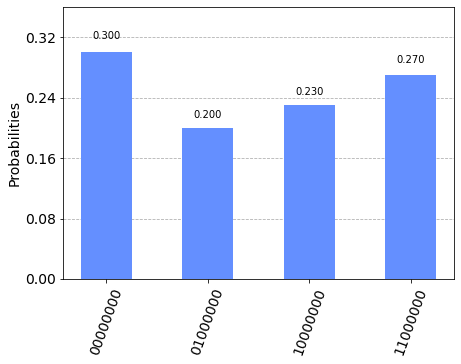

In [11]:
""" Construct Quantum Hardware Simulator """

def simulator(circuit, n_shots):
    """
    Simulates the circuit on Qiskit infrastructure.
    
    Simulates n_shots, and returns the results.
    """
    # Create simulator backend
    qasm_sim = Aer.get_backend('qasm_simulator')

    # Transfer curcuit onto backend
    trans = transpile(circuit, qasm_sim)
    assembly = assemble(trans, shots=n_shots)

    #get simulated results
    results = qasm_sim.run(assembly, memory=True).result()
    #true memory allows access to every individual shot
    
    return results

""" Test the QPE_3 circuit on the simulator """
#a = 7, n_count = 8
demo = QPE_3(7, 8)
results = simulator(demo, 100) # 100 shots
#show histogram of results
plot_histogram(results.get_counts())
#2**8 = 256
#00000000 = 0 -> phase = 0
#01000000 = 64 -> phase = 1/4
#10000000 = 128 -> phase = 2/4 = 1/2
#11000000 = 192 -> phase = 3/4

In [12]:
def shor_circuit_15(a, n_count):
    """
    Creates a circuit that runs shor's algorithm,
    runs it once on the simulator, and returns the result.
    """
    circuit = QPE_3(a, n_count) #get circuit
    #run once
    results = simulator(circuit, 1)
    #get result
    reading = results.get_memory()[0]
    return reading #returns binary representation
    
""" Show example of show_circuit_15() """
# a = 7, n_count = 8
print(shor_circuit_15(7, 8))

00000000


In [13]:
""" Implement non-circuit math """

def run_shor_15(a, n_count):
    """
    This function runs shor's algorithm on the simulator, and actually
    uses the result to find the factors of 15.
    
    Returns list [factor_1, factor_2]
    """
    #get result of simulation
    binary_result = shor_circuit_15(a, n_count)
    #convert result from binary to integer
    result = int(binary_result, 2)
    
    #convert result into phase = s/r
    phase = result/(2**n_count)
    
    #convert phase s/r into fraction
    frac = Fraction(phase).limit_denominator(15) #limit denominator to 15 to prevent rounding errors
    #find denominator of s/r
    r = frac.denominator #period
    print("r:", r)
    
    #use Euclid's algorithm to convert from period to factors
    factors = [gcd(a**(r//2)-1, 15), gcd(a**(r//2)+1, 15)]
    return factors

"""
Note: sometimes s shares a common factor with r, so finding the denominator will give an
incorrect result. This error is corrected by repeated trials.
"""

""" Show example of run_shor_15() """
# a = 7, n_count = 8
print(run_shor_15(7, 8))    

r: 1
[15, 1]


In [14]:
""" Full Implementation of Shor's algorithm """

"""
This is a full implentation of shor's algorithm for 15.
Choosing some random a, we find the period of a mod15,
and use that to find the factors of 15. We repeat this until
we find satisfactory factors.

Given the posibilities of s sharing a factor with r, and r
yielding 15 and 1 as factors, it turns out that the average trial
as a 3/8 chance of producing satisfactory factors.
So, we still have about a 99% chance of finding the factors within 10 tries.
"""

N_COUNT = 8 #number of counting qubits to use

tries = 0 #track number of tries
guesses = [0, 0] #guesses produced by trial

#repeat until satisfying guesses are found
#should actually be factors of 15 and not be 1 and 15
while (not guesses[0]*guesses[1]==15) or 15 in guesses:
    tries += 1
    
    #choose random a that we can work with
    i = randint(len(VALID_A))
    a = VALID_A[i]
    
    print("try:", tries)
    print("a:", a)
    
    #use shor's algorithm to guess factors
    guesses = run_shor_15(a, N_COUNT) #function prints r
    print("guess:", guesses)
    print("\n")

#guesses passes tests
print("Factors found!")
print("The factors of 15 are", guesses[0], "and", guesses[1], "!")

try: 1
a: 2
r: 1
guess: [15, 1]


try: 2
a: 7
r: 1
guess: [15, 1]


try: 3
a: 2
r: 4
guess: [3, 5]


Factors found!
The factors of 15 are 3 and 5 !
